困惑度 1.4, 88949.9 标记/秒 cuda:0
time travellerit s against reason said filbywhat ve collow you s
travellerit s against reason said filbywhat ve collow you s


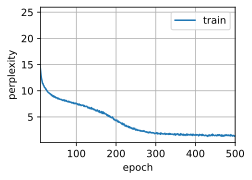

In [2]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class RNNModelScratch:
    def __init__(self, batch_size, vocab_size, num_hiddens, device_name):
        self.vocab_size = vocab_size 
        self.num_hiddens = num_hiddens
        self.device = device_name
        self.params  = self.params(vocab_size, num_hiddens, self.device)
        # self.state = (torch.zeros((batch_size, num_hiddens), device=device_name),)

    def __call__(self, inputs, state):
         inputs = F.one_hot(inputs.T, self.vocab_size).type(torch.float32)
         inputs = inputs.to(self.device)
         W_xh, W_hh, b_h, W_hq, b_q = self.params
         H, = state
         outputs = []
         for X in inputs:
            H = torch.tanh(torch.mm(X,W_xh) + torch.mm(H, W_hh) + b_h)
            Y = torch.mm(H,W_hq) + b_q
            outputs.append(Y)
         return torch.cat(outputs, dim=0), (H,)


    def normal(self, shape):
        return torch.randn(size=shape, device=self.device) * 0.01

    def params(self, vocab_size, num_hiddens, device):
        num_inputs = num_outputs = vocab_size

        W_xh = self.normal((num_inputs, num_hiddens))
        W_hh = self.normal((num_hiddens,num_hiddens))
        b_h = torch.zeros(num_hiddens,device=self.device)

        W_hq = self.normal((num_hiddens, num_outputs))
        b_q = torch.zeros(num_outputs, device=self.device)

        params = [W_xh, W_hh, b_h, W_hq, b_q]

        for param in params:
            param.requires_grad_(True)
        
        return params 

def begin_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

def grad_clipping(net, theta):  
    """裁剪梯度。"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm


def predict_next_char(net, prefix, num_preds, num_hiddens, vocab, device):

    state = begin_state(1, num_hiddens, device)
    outputs = [vocab[prefix[0]]]
    get_next =  lambda: torch.tensor([outputs[-1]], device=device).reshape((1,1))

    for y in prefix[1:]:
        _, state = net(get_next(), state)
        outputs.append(vocab[y])
    
    for i in range(num_preds):
        y, state  = net(get_next(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))

    return ''.join([vocab.idx_to_token[i] for i in outputs])



def train_one_step(net, state, train_iter, loss, updater, lr, device):
    timer = d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        for s in state:
            s.detach()
        y = Y.T.reshape(-1).to(device)
        l = loss(net(X, state)[0], y).mean()
        l.backward() 
        grad_clipping(net, 1)
        updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0]/ metric[1]), metric[1] / timer.stop()


def train_rnn(net, state,  train_iter, loss, updater, lr, device, epoch):
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, epoch])
    predict = lambda prefix: predict_next_char(net, prefix, 50, num_hiddens, vocab, device)
    for epoch in range(epoch):
        ppl, speed = train_one_step(net, state, train_iter, loss, updater, lr, device)
        # print(predict('time traveller'))
        animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 标记/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))


batch_size = 32
num_steps =  35
num_hiddens = 512
lr = 1 
epoch = 500

train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
test_rnn = RNNModelScratch(batch_size, len(vocab), num_hiddens, d2l.try_gpu())
loss = nn.CrossEntropyLoss()
updater = lambda batch_size: d2l.sgd(test_rnn.params, lr, batch_size)
state = begin_state(batch_size, num_hiddens, d2l.try_gpu())

train_rnn(test_rnn, state, train_iter, loss, updater, lr, d2l.try_gpu(), epoch)



困惑度 1.1, 91823.3 标记/秒 cuda:0
time traveller with a slight accession ofcheerfulness really thi
travelleryou can show black is white by argument said filby


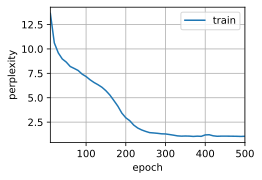

In [3]:


batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)


def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)


def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)



class RNNModelScratch:  
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)



def predict_ch8(prefix, num_preds, net, vocab, device):  
    """在`prefix`后面生成新字符。"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])


def grad_clipping(net, theta):  
    """裁剪梯度。"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm


def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练模型一个迭代周期（定义见第8章）。"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()



def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）。"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 标记/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

    
num_hiddens = 512
num_epochs, lr = 500, 1
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

